In [1]:
!pip install --upgrade pip
!pip install --upgrade allennlp
!pip install transformers==4.3.0

     |████████████████████████████████| 1.5 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.0.1
    Uninstalling pip-21.0.1:
      Successfully uninstalled pip-21.0.1
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 625 kB 2.9 MB/s eta 0:00:01
  Attempting uninstall: allennlp
    Found existing installation: allennlp 2.3.0
    Uninstalling allennlp-2.3.0:
      Successfully uninstalled allennlp-2.3.0
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 1.8 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: 

In [2]:
!pip install datasets==1.2.1 #to load xnli and mnli datasets from huggingface library
!pip install googletrans==3.1.0a0

distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 159 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 4.0 MB/s  eta 0:00:01
     |████████████████████████████████| 243 kB 13.9 MB/s eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.59.0
    Uninstalling tqdm-4.59.0:
      Successfully uninstalled tqdm-4.59.0
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
     |████████████████████████████████| 55 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 994 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 12.8 MB/s eta 0:00:01
     |███████████████

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import os.path
from os import path
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv
/kaggle/input/backtranslations-for-data-augmentation-in-nlp/back_translated_data.csv


In [4]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [5]:
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    
from transformers import (XLMRobertaConfig, XLMRobertaTokenizer, TFXLMRobertaModel)            

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D, LayerNormalization
from keras.layers.normalization import BatchNormalization

from datasets import load_dataset, list_datasets
from tqdm import tqdm

from googletrans import Translator
# from google_trans_new import google_translator 

import time
import glob

# Resets all state generated by Keras
K.clear_session()

# For reproducibility
np.random.seed(0)

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Found TPU: ', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Found TPU:  grpc://10.0.0.2:8470
Number of replicas: 8


In [14]:
# Configuration Settings
EPOCHS = 5
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 120
PATIENCE = 1
LEARNING_RATE = 1e-5
AUTO = tf.data.experimental.AUTOTUNE
LOAD_XNLI = True
LOAD_MNLI = True
BACK_TRANSLATE = True
BT_DIR = '../input/backtranslations-for-data-augmentation-in-nlp' #directory containing the back translations of input training data

In [8]:
train_df = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_df = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

# check the number of rows and columns in the datasets
print("Training data shape: {}".format(train_df.shape))
print("Test data shape: {}\n".format(test_df.shape))

train_df.head()

Training data shape: (12120, 6)
Test data shape: (5195, 5)



,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [9]:
def process_xnli_data(test_df, all_keys=False, only_train=False): 
    if only_train:
        print ("Splitting by train data only")
        split = 'train'
    elif all_keys:
        print ("Splitting by all keys")
        split = 'validation+test+train[:5%]'
    else:
        print ("Splitting by validation and test data")
        split = 'validation+test'
    
    print("Loading XNLI data...")
    print("Split: ", split)
    
    dataset = load_dataset('xnli', 'all_languages', split=split) #returns a Dataset object  
    print(dataset)
    
    entries = []   
    for entry in tqdm(dataset): 
        hypothesis_langs = entry['hypothesis']['language'] #list of 15 lang string values
        hypothesis_values = entry['hypothesis']['translation'] #list of 15 hypothesis string values

        premise_langs = list(entry['premise'].keys()) #list of 15 lang string values
        premise_values = list(entry['premise'].values()) #list of 15 premise string values

        labels = [entry['label']]*len(hypothesis_langs) #all 15 languages for the same example have same label 

        if premise_langs == hypothesis_langs: #the languages in premise and hypothesis are in same order
#             values = list(zip(premise_values, hypothesis_values, hypothesis_langs, labels))
            values = list(zip(premise_values, hypothesis_values, labels))
            entries += values

#     xnli_df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'lang_abv', 'label']) #create dataframe for each key
    xnli_df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'label']) #create dataframe for each key
    
    # Get the number of missing data points per column
    missing_values_xnli = xnli_df.isnull().sum() 

    print("Number of missing data points per column in XNLI corpus:")
    print (missing_values_xnli)

    # Drop the missing value rows
    xnli_df.dropna(axis=0, inplace=True)
    print("Total number of data examples in XNLI corpus after dropping NA values: {}".format(xnli_df.shape[0]))
    
    ################## Delete duplicate rows between test_df and xnli_df in xnli corpus #########################
    xnli_df = xnli_df.drop_duplicates() #drop duplicate rows
    print('Total number of data examples in XNLI corpus after dropping duplicate values: {}'.format(xnli_df.shape[0]))
    
    print('Test data shape: {}'.format(test_df.shape))
    test_df = test_df.drop_duplicates() #drop duplicate rows
    print('Test data shape after dropping duplicate rows: {}'.format(test_df.shape))

    df_merge = pd.merge(xnli_df, test_df, on=['premise','hypothesis'], how='inner')
    xnli_df = xnli_df.append(df_merge, ignore_index=True) 

    xnli_df['duplicated'] = xnli_df.duplicated(subset=['premise','hypothesis'], keep=False) # keep=False marks the duplicated row with a True
    xnli_df = xnli_df[~xnli_df['duplicated']] # selects only rows which are not duplicated.
    
    xnli_df.drop(['duplicated', 'id', 'lang_abv', 'language'], axis = 1, inplace=True) # remove following columns
    ################## Delete duplicate rows between test_df and xnli_df in xnli corpus #########################
    
    print("XNLI corpus shape: {}".format(xnli_df.shape))
    
    del dataset #free up space
    
    return xnli_df

In [10]:
def process_mnli_data(validation=False):
    if validation:
        keys = ['train', 'validation_matched', 'validation_mismatched']
    else:
        keys = ['train']
    
    dataset = load_dataset('glue', name='mnli') #returns a DatasetDict object
    print(dataset)
    
    df_dict = {}
    
    for key in tqdm(keys):
        print("Processing MNLI {} data...".format(key))
        
        hypothesis = dataset[key]['hypothesis']
        premise = dataset[key]['premise']
        labels = dataset[key]['label']
        
        entries = list(zip(premise, hypothesis, labels))
        
        df = pd.DataFrame(entries, columns=['premise', 'hypothesis', 'label']) #create dataframe for each key
        df_dict[key] = df
        
    if validation:
        mnli_df = pd.concat([df_dict['train'], df_dict['validation_matched'], df_dict['validation_mismatched']], ignore_index=True)
    else:
        mnli_df = df_dict['train']
    
    # Get the number of missing data points per column
    missing_values_mnli = mnli_df.isnull().sum() 

    print("Number of missing data points per column in MNLI corpus:")
    print (missing_values_mnli)

    # Drop the missing value rows from training set
    mnli_df.dropna(axis=0, inplace=True)
    print("Total number of data examples in MNLI corpus after dropping NA values: {}\n".format(mnli_df.shape[0]))
    
    del dataset #free up space
    
    return mnli_df

In [12]:
def back_translate(train_df, target_lang='fr', sample=True, num_samples_per_lang=1000):
    if sample: #sample input training data to back translate
        train_df = train_df.groupby('language', group_keys=False).apply(lambda x: x.sample(min(len(x), num_samples_per_lang))).reset_index(drop=True)  

    df_list = []
    limit_before_timeout = 100
    timeout = 5
    
    translator = Translator() 
    
    # Add functions to back translate input sentences
    def target_translate(x, target_lang):
        translation = translator.translate(x, dest=target_lang)
        return translation.text
    def source_translate(x, source_lang):
        translation = translator.translate(x, dest=source_lang) 
        return translation.text 
    
    for i in tqdm(range(len(train_df))):
        entry = train_df.loc[[i]]
        source_lang = entry.lang_abv.values.tolist()[0]
        if source_lang == 'zh':
            #print(googletrans.LANGUAGES) 
            source_lang = 'zh-cn' #'zh' not in googletrans.LANGUAGES        
        if (i!=0) and (i%limit_before_timeout == 0): #apply timeout after every 100 iterations 
            print('Iteration {} of {}'.format(i, len(train_df)))
            time.sleep(timeout)      
        # Back translate premise sentence
        entry['premise'] = entry['premise'].apply(lambda x: target_translate(x, target_lang))
#         time.sleep(0.2)
        entry['premise'] = entry['premise'].apply(lambda x: source_translate(x, source_lang))
#         time.sleep(0.2)       
        # Back translate hypothesis sentence
        entry['hypothesis'] = entry['hypothesis'].apply(lambda x: target_translate(x, target_lang))
#         time.sleep(0.2)
        entry['hypothesis'] = entry['hypothesis'].apply(lambda x: source_translate(x, source_lang))
#         time.sleep(0.2)
        df_list.append(entry)
    
    train_bt = pd.concat(df_list, ignore_index=True)
    print("Shape of back-translated training data: {}".format(train_bt.shape))
    return train_bt

In [15]:
def augment_data(df, use_xnli=True, use_mnli=True, use_bt=True, bt_dir=''):
    df_list = []  
    if use_bt:
        if path.isdir(bt_dir):
            files = glob.glob(bt_dir+'/*.csv')
            bt_list = []
            for filename in files:
                bt_list.append(pd.read_csv(filename))
            bt_df = pd.concat(bt_list, ignore_index=True)
#             bt_df.isnull().sum() # we get the number of missing values
            bt_df.dropna(inplace=True) #remove missing values
            bt_df.drop_duplicates(inplace=True) #drop duplicate rows  
            bt_df = bt_df.sample(frac=0.4) #randomly select n examples as back-translated data 
            print("Shape of back-translated training data: {}".format(bt_df.shape))
            bt_df.to_csv('back_translation_all.csv', index=False)
        else:
            bt_df = back_translate(df)
        bt_df = bt_df.drop(['id', 'lang_abv', 'language'], axis=1)
        df_list.append(bt_df)
        del bt_df #free up space 
    if use_xnli:
        xnli_df = process_xnli_data(test_df)
#         xnli_train_df = process_xnli_data(test_df, only_train=True) #train data, around 5 million examples
#         xnli_train_df = xnli_train_df.sample(frac=0.05) #sample 5% of train data
#         xnli_df = process_xnli_data(test_df) #val+test
#         xnli_df = xnli_df.append(xnli_train_df, ignore_index=True) #val+test+train[5%]
#         print ('Final XNLI shape: {}'.format(xnli_df.shape))
        df_list.append(xnli_df)
        del xnli_df #free up space 
    if use_mnli:
        mnli_df = process_mnli_data(validation=False)
        df_list.append(mnli_df)
        del mnli_df #free up space
        
    train_df = df.drop(['id', 'lang_abv', 'language'], axis=1)
    
    if len(df_list) > 0: #augment data
        augmented_df = pd.concat(df_list, ignore_index=True)
        train_df = train_df.append(augmented_df, ignore_index=True) 
        
    train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle data
    print("Augmented data shape before removing duplicate rows: {}".format(train_df.shape))
    train_df.drop_duplicates(inplace=True) #drop duplicate rows
    print("Augmented data shape after removing duplicate rows: {}".format(train_df.shape))
    return train_df


train_df = augment_data(train_df, LOAD_XNLI, LOAD_MNLI, BACK_TRANSLATE, BT_DIR) 
train_df.head(100)

Shape of back-translated training data: (4778, 6)
Splitting by validation and test data
Loading XNLI data...
Split:  validation+test


  7%|▋         | 553/7500 [00:00<00:01, 5524.42it/s]

Dataset xnli downloaded and prepared to /root/.cache/huggingface/datasets/xnli/all_languages/1.1.0/51ba3a1091acf33fd7c2a54bcbeeee1b1df3ecb127fdca003d31968fa3a1e6a8. Subsequent calls will reuse this data.
Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 7500
})


100%|██████████| 7500/7500 [00:01<00:00, 5559.38it/s]


Number of missing data points per column in XNLI corpus:
premise       0
hypothesis    0
label         0
dtype: int64
Total number of data examples in XNLI corpus after dropping NA values: 112500
Total number of data examples in XNLI corpus after dropping duplicate values: 112500
Test data shape: (5195, 5)
Test data shape after dropping duplicate rows: (5195, 5)
XNLI corpus shape: (110226, 3)


  0%|          | 0/1 [00:00<?, ?it/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/7c99657241149a24692c402a5c3f34d4c9f1df5ac2e4c3759fadea38f6cb29c4. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
Processing MNLI train data...


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


Number of missing data points per column in MNLI corpus:
premise       0
hypothesis    0
label         0
dtype: int64
Total number of data examples in MNLI corpus after dropping NA values: 392702

Augmented data shape before removing duplicate rows: (519826, 3)
Augmented data shape after removing duplicate rows: (512850, 3)


,premise,hypothesis,label
0,It has an interesting story to tell.,It was interesting to explain what happened wh...,1
1,it's gotten so though that there are so many y...,There's a very large amount now - it's become ...,0
2,我们也强调与历史，文学和社会研究主题直接相关的剧本。,我们尽量不制作着眼于历史或文学的戏剧。,2
3,This parallel obsession elicited the interesti...,The obsession elicited a suggestion that all o...,1
4,It seems to me an unnecessary expense to spend...,I firmly feel that it is right to spend millio...,2
...,...,...,...
95,Ha! Wolverstone trút sự xuất tinh của việc sin...,Wolverstone không cười.,2
96,دھماکے میں چھ افراد جاں بحق، تقریبا 1000 زخمی ...,دھماکے میں تقریبا ایک ہزار افراد زخمی ہوگئے.,0
97,ابوبکر کے ساتھ ابرام کے ساتھ، بندرگاہ میں، اس ...,Arabella ایک چھوٹے سے شہر میں آیا جس کی زندگی ...,2
98,When Hideyoshi built his main castle in the ce...,Hideyoshi building his castle in Osaka in 1583...,2


In [16]:
# check the number of rows and columns in the augmented train data
print("Augmented train data shape: {}".format(train_df.shape))

Augmented train data shape: (512850, 3)


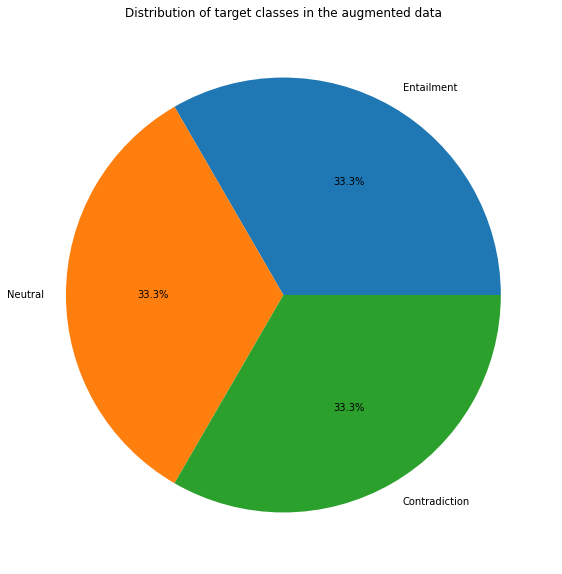

In [17]:
# check distribution of target classes in the augmented data
counts = train_df['label'].value_counts()

class_labels = ['Entailment', 'Neutral', 'Contradiction']

counts_per_class = [counts[0], counts[1], counts[2]]

plt.figure(figsize = (10,10))
plt.pie(counts_per_class, labels = class_labels, autopct = '%1.1f%%')
plt.title("Distribution of target classes in the augmented data")
plt.show()

In [18]:
PRETRAINED_MODEL_TYPES = {
    'xlmroberta': (XLMRobertaConfig, TFXLMRobertaModel, XLMRobertaTokenizer, 'jplu/tf-xlm-roberta-large')
}

config_class, model_class, tokenizer_class, model_name = PRETRAINED_MODEL_TYPES['xlmroberta']

In [19]:
# Download vocabulary from huggingface.co and cache.
# tokenizer = tokenizer_class.from_pretrained(model_name) 
tokenizer = AutoTokenizer.from_pretrained(model_name) #fast tokenizer

tokenizer

PreTrainedTokenizerFast(name_or_path='jplu/tf-xlm-roberta-large', vocab_size=250002, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [20]:
def encode(df, tokenizer, max_len=50, cross_val=False):
    
    pairs = df[['premise','hypothesis']].values.tolist() #shape=[num_examples]
    
    print ("Encoding...")
    encoded_dict = tokenizer.batch_encode_plus(pairs, max_length=max_len, padding=True, truncation=True, 
                                               add_special_tokens=True, return_attention_mask=True)
    print ("Complete")
    
    if cross_val:
        input_word_ids = np.array(encoded_dict['input_ids']) #shape=[num_examples, max_len])
        input_mask = np.array(encoded_dict['attention_mask']) #shape=[num_examples, max_len]
    else:
        input_word_ids = tf.convert_to_tensor(encoded_dict['input_ids'], dtype=tf.int32) #shape=[num_examples, max_len])
        input_mask = tf.convert_to_tensor(encoded_dict['attention_mask'], dtype=tf.int32) #shape=[num_examples, max_len]


    inputs = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask}    
    
    return inputs

In [21]:
def build_model(model_name, max_len=50):
    
    tf.random.set_seed(1234)
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    
    # The bare XLM-RoBERTa Model transformer outputting raw hidden-states without any specific head on top.
    base_model = model_class.from_pretrained(model_name)
#     base_model = TFAutoModel.from_pretrained(model_name)
    
#     # Extract pretrained embedding vectors
#     embedding = base_model([input_word_ids, input_mask])[0] # shape=(batch_size, max_len, embed_size)
#     # We pass the embedding vectors of only the 'cls' token (at index=0) to the dense layer
#     sequence_output = embedding[:,0,:] #shape=(batch_size, embed_size)

    
    ### pooler_output contains the hidden representation of just the ‘[CLS]’ token after additionally being passed to a fully connected layer with tanh activation function.
    ### output = base_model([input_word_ids, input_mask], training=False) # output from xlmroberta model
    output = base_model([input_word_ids, input_mask]) # output from xlmroberta model
    sequence_output = output.pooler_output #shape: [batch_size, embed_size]
    ### sequence_output = Dropout(0.3)(sequence_output) #add dropout
    
#     # Add an LSTM layer to get sentence embeddings
#     sequence_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, dropout=0.3, recurrent_dropout=0.3))(embedding) # shape=(batch_size, output_size) 
# #     sequence_output = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(150, dropout=0.3, recurrent_dropout=0.3))(embedding) # shape=(batch_size, output_size) 
    
#     # Add a fully-connected layer
#     sequence_output = tf.keras.layers.Dense(300, activation="relu")(sequence_output)
#     sequence_output = BatchNormalization()(sequence_output)
#     sequence_output = tf.keras.layers.Dropout(0.3)(sequence_output) 
    
    # Add a classification layer
    output = Dense(units=3, activation="softmax")(sequence_output)
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
def create_dataset(features, labels, batch_size=BATCH_SIZE, validation=False):
    dataset = tf.data.Dataset.from_tensor_slices((features, labels)).shuffle(len(features))
    if validation:
        dataset = dataset.batch(batch_size).prefetch(AUTO)
    else:
        dataset = dataset.repeat().batch(batch_size).prefetch(AUTO)
    return dataset

In [23]:
train_input = encode(train_df, tokenizer=tokenizer, max_len=MAX_LEN, cross_val=True)

Encoding...
Complete


In [24]:
train_ids = train_input['input_word_ids'] #[9696, max_len]
train_mask = train_input['input_mask'] #[9696, max_len]

In [25]:
print(train_ids.shape)
print(train_mask.shape)

(512850, 120)
(512850, 120)


In [27]:
train_labels = train_df.label.values

In [28]:
print(train_labels.shape)

(512850,)


In [31]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint

# prepare cross validation
folds = 4
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1)

# for plotting
val_loss_list = []
val_acc_list = []
train_hist_list = []

callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE)]

# enumerate splits
for k, (train_idx, val_idx) in enumerate(kfold.split(train_ids, train_labels)):
    print ('Fold {} of {}'.format(k+1, folds))
    print('Train data shape: {}, Validation data shape: {}'.format(len(train_idx), len(val_idx)))
    print('Train indices: {}, Validation indices: {}'.format(train_idx, val_idx))
    
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    training_data = create_dataset((train_ids[train_idx], train_mask[train_idx]), train_labels[train_idx], batch_size=BATCH_SIZE, validation=False)
    validation_data = create_dataset((train_ids[val_idx], train_mask[val_idx]), train_labels[val_idx], batch_size=BATCH_SIZE, validation=True)
    
    # instantiating the model in the strategy scope creates the model on the TPU
    with strategy.scope():
        model = build_model(model_name, MAX_LEN)
        model.summary()
        
    n_steps = int(len(train_idx)/BATCH_SIZE)
    
    train_history = model.fit(x=training_data, validation_data=validation_data, epochs=EPOCHS, verbose=1, steps_per_epoch=n_steps, callbacks=callbacks)
    
    avg_val_loss = np.mean(train_history.history['val_loss'])
    avg_val_acc = np.mean(train_history.history['val_accuracy'])
    
    print ('Average Validation Loss: {}'.format(avg_val_loss))
    print ('Average Validation Accuracy: {}'.format(avg_val_acc))
    print('#############################################\n')
    
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)
    train_hist_list.append(train_history)
    
    del model #free up space
            
    # Resets all state generated by Keras before training a new model in the next fold
    K.clear_session()

Fold 1 of 4
Train data shape: 384637, Validation data shape: 128213
Train indices: [     0      1      2 ... 512845 512846 512847], Validation indices: [     5      6      9 ... 512844 512848 512849]


Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            3075        tfxlm_roberta_model[0][1]    

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3004/3004 [==============================] - 917s 265ms/step - loss: 0.5701 - accuracy: 0.7431 - val_loss: 0.3301 - val_accuracy: 0.8783
Epoch 2/5
3004/3004 [==============================] - 778s 259ms/step - loss: 0.3098 - accuracy: 0.8832 - val_loss: 0.3106 - val_accuracy: 0.8882
Epoch 3/5
3004/3004 [==============================] - 778s 259ms/step - loss: 0.2361 - accuracy: 0.9139 - val_loss: 0.3166 - val_accuracy: 0.8911
Epoch 00003: early stopping
Average Validation Loss: 0.31910763184229535
Average Validation Accuracy: 0.8858851989110311
#############################################

Fold 2 of 4
Train data shape: 384637, Validation data shape: 128213
Train indices: [     1      2      5 ... 512847 512848 512849], Validation indices: [     0      3      4 ... 512838 512842 512846]


Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            3075        tfxlm_roberta_model[0][1]    

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            3075        tfxlm_roberta_model[0][1]    

Some layers from the model checkpoint at jplu/tf-xlm-roberta-large were not used when initializing TFXLMRobertaModel: ['lm_head']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at jplu/tf-xlm-roberta-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 3)            3075        tfxlm_roberta_model[0][1]    

<a id='table'></a>

| Fold | Avg Val Loss | Avg Val Accuracy |
| --- | --- | --- |
| 1 | 0.319 | 0.886 | 
| 2 | 0.343 | 0.882 | 
| 3 | 0.342 | 0.885 |
| 4 | 0.333 | 0.883 |

We perform k-fold cross-validation on our best model and the above table documents how the model performs across each individual validation fold when k=4. We can see that the validation performance is stable and doesn't fluctuate much with ±0.024 in average validation loss and ±0.004 in validation accuracy across all folds. Hence we can say that our model is robust against small perturbations in the training data.

In [32]:
mean_val_loss = round(np.mean(val_loss_list), 3)
mean_val_acc = round(np.mean(val_acc_list), 3)

print('Average validation loss over all folds: {}'.format(mean_val_loss))
print('Average validation accuracy over all folds: {}'.format(mean_val_acc))

Average validation loss over all folds: 0.335
Average validation accuracy over all folds: 0.884
